In [1]:
import sys
sys.path.append('/home/ngr/gdrive/wearables/scripts')
import data as weardata

import numpy as np

In [2]:
data = weardata.load_pp_actigraphy()

In [42]:
def split_pp_actigraphy(data):
    pids = np.unique([i.split('-')[0] for i in data.keys()])
    train_pids = np.random.choice(pids, int(len(pids)*0.8), replace=False)
    test_pids = [i for i in pids if i not in train_pids]
    
    train_keys, test_keys = [], []
    for k in data.keys():
        if k.split('-')[0] in train_pids:
            train_keys.append(k)
        elif k.split('-')[0] in test_pids:
            test_keys.append(k)
        else:
            print('{} dict key not found or sorted')
            
    return {k:data[k] for k in train_keys}, {k:data[k] for k in test_keys}

In [72]:
def pad_align_transform(data):
    X = np.empty((len(data.keys()), 24*60))
    y = np.empty((len(data.keys()),))
    for i, (k, v) in enumerate(data.items()):
        ts, act = v[0], v[1]
        first_hour, first_min = ts[0].hour, ts[0].minute
        zeros2pad = np.zeros((first_hour*60 + first_min + 1))
        act = np.concatenate((zeros2pad, [float(i) for i in act[:24*60 - zeros2pad.shape[0]]]))
        if act.shape[0] < 24*60:
            act = np.concatenate((act, np.zeros((24*60-act.shape[0], ))))
        
        # add log-pseudocount
        act = np.log(act + 1)
        X[i, :] = act
        y[i] = int(k.split('-')[1])
    return X, y
        


In [73]:
# get train/test
X_train, y_train = pad_align_transform(train_data)
X_test, y_test = pad_align_transform(test_data)

In [90]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

cv_scores = 
clf = KernelRidge(alpha=0.1)
# scores = cross_val_score(clf, X_train, y_train, scoring='r2')
# n_samples, n_features = 10, 5
# rng = np.random.RandomState(0)
# y = rng.randn(n_samples)
# X = rng.randn(n_samples, n_features)
# clf = KernelRidge(alpha=1.0)
# clf.fit(X, y)

KernelRidge(alpha=0.1)

In [93]:
mean_absolute_error(y_train, clf.predict(X_train))

7.098047419986828

In [94]:
mean_absolute_error(y_test, clf.predict(X_test))

13.359774591220422

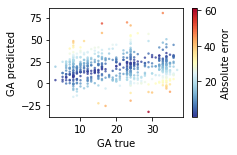

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3,2))
pred = clf.predict(X_test)
true = y_test
im = ax.scatter(true, pred, s=6, edgecolor='none', alpha=0.8, c=np.abs(pred-true), cmap='RdYlBu_r', rasterized=True)
ax.set_xlabel('GA true')
ax.set_ylabel('GA predicted')
cbar = fig.colorbar(im)
cbar.set_label('Absolute error')

fig.savefig('/home/ngr/Downloads/krr.png', dpi=600, bbox_inches='tight')